<table width="100%"><tr><td style="color:#bbbbbb;background-color:#ffffff;font-size:11px;font-style:italic;text-align:right;">This cell contains some macros. If there is a problem with displaying mathematical formulas, please run this cell to load these macros. </td></tr></table>
$ \newcommand{\bra}[1]{\langle #1|} $
$ \newcommand{\ket}[1]{|#1\rangle} $
$ \newcommand{\braket}[2]{\langle #1|#2\rangle} $
$ \newcommand{\dot}[2]{ #1 \cdot #2} $
$ \newcommand{\biginner}[2]{\left\langle #1,#2\right\rangle} $
$ \newcommand{\mymatrix}[2]{\left( \begin{array}{#1} #2\end{array} \right)} $
$ \newcommand{\myvector}[1]{\mymatrix{c}{#1}} $
$ \newcommand{\myrvector}[1]{\mymatrix{r}{#1}} $
$ \newcommand{\mypar}[1]{\left( #1 \right)} $
$ \newcommand{\mybigpar}[1]{ \Big( #1 \Big)} $
$ \newcommand{\sqrttwo}{\frac{1}{\sqrt{2}}} $
$ \newcommand{\dsqrttwo}{\dfrac{1}{\sqrt{2}}} $
$ \newcommand{\onehalf}{\frac{1}{2}} $
$ \newcommand{\donehalf}{\dfrac{1}{2}} $
$ \newcommand{\hadamard}{ \mymatrix{rr}{ \sqrttwo & \sqrttwo \\ \sqrttwo & -\sqrttwo }} $
$ \newcommand{\vzero}{\myvector{1\\0}} $
$ \newcommand{\vone}{\myvector{0\\1}} $
$ \newcommand{\vhadamardzero}{\myvector{ \sqrttwo \\  \sqrttwo } } $
$ \newcommand{\vhadamardone}{ \myrvector{ \sqrttwo \\ -\sqrttwo } } $
$ \newcommand{\myarray}[2]{ \begin{array}{#1}#2\end{array}} $
$ \newcommand{\X}{ \mymatrix{cc}{0 & 1 \\ 1 & 0}  } $
$ \newcommand{\Z}{ \mymatrix{rr}{1 & 0 \\ 0 & -1}  } $
$ \newcommand{\Htwo}{ \mymatrix{rrrr}{ \frac{1}{2} & \frac{1}{2} & \frac{1}{2} & \frac{1}{2} \\ \frac{1}{2} & -\frac{1}{2} & \frac{1}{2} & -\frac{1}{2} \\ \frac{1}{2} & \frac{1}{2} & -\frac{1}{2} & -\frac{1}{2} \\ \frac{1}{2} & -\frac{1}{2} & -\frac{1}{2} & \frac{1}{2} } } $
$ \newcommand{\CNOT}{ \mymatrix{cccc}{1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & 1 & 0} } $
$ \newcommand{\norm}[1]{ \left\lVert #1 \right\rVert } $
$ \newcommand{\pstate}[1]{ \lceil \mspace{-1mu} #1 \mspace{-1.5mu} \rfloor } $

#  Quantum Approximate Optimization Algorithm (QAOA)

In this notebook, we will introduce the Quantum Approximate Optimization Algorithm (QAOA) and see how to implement the algorithm for the Max-Cut problem using pyQuil, the Python library for quantum programming using Quil from Rigetti Computing following [1]. Instructions on how to install pyQuil can be found [here](https://pyquil-docs.rigetti.com/en/stable/index.html).


## What is QAOA?

QAOA, first introduced by Farhi et al. [2], is a hybrid quantum-classical algorithm (using both classical and quantum computation) that helps find an approximate solution for combinatoral optimization problems. 


## What are Combinatorial Optimization Problems?

In a combinatorial optimization problem, the goal is that given some binary constraints $\alpha$ over bitstrings of length n, $\it{z}\in \{0,1\}^{n}$, we want to find the bitstring that maximizes the objective function
$$
C (\it{z}) =\sum_{\alpha =1}^{m} C_{\alpha} (\it{z}),
$$
where 
$$
C_{\alpha} (\it{z}) = \begin{cases}
1, & \text{if} \, \it{z} \, \text{satisfies the constraint} \, \alpha \\
0, & \text{if} \, \it{z} \, \text{does not satisfy the constraint} \,\alpha
\end{cases}
$$

are functions that takes in a bitstring and outputs $0$ or $1$, depending on whether it satisfies the constraint. 

There are various different examples such as the Traveling Salesman problem and Max-Cut problem. Here, we will focus on solving a Max-Cut problem with QAOA.


## Why QAOA?

In QNickel, we saw an example of solving the Max-Cut problem with Grover's algorithm, so the question is why use QAOA? The answer is although there has been great progress, we do not have fault-tolerant quantum computers yet. So in the meantime, we use a quantum-classical hybrid approach, so that we only use quantum computers for parts of the problem where cassical computers having difficulty computing.

## How does QAOA work?

QAOA is a hybrid algorithm. A general hybrid algorithm works as follows.

<img src="Hybrid.png" width="50%">

There is a classical processing unit (CPU) and quantum processing unit (QPU). The idea is:

1) The CPU sends a parametrized circuit to the QPU with some initial guess of parameters.

2) The QPU will then run this circuit for a number of shots for some observable to get a sample.

3) We feed the sample back to the CPU. 

4) The CPU can then further optimize parameters for the objective function.

You repeat this cycle until you get a convergence to a good choice of parameters that optimizes your objective function.



## Application of QAOA to the Max-Cut Problem

Now let us look at a more specific example, the Max-Cut problem with QAOA. Consider the folowing undirected graph with four nodes and five edges.

<img src="FourNode.png" width="25%" align="center">

The Max-Cut problem is to find a partition of the nodes of the such that the edges between them is maximum or the maximum number of cuts of edges such that the ends of nodes are different colors. We can easily see that for this graph, the Max-Cut would be four and we choose to represent the partition of nodes with two colors, red and blue, and either of the following colorings would be valid.

<img src="MaxCut.png" width="55%" align="center">

The solution to this problem can also be represented in binary format with qubits by taking the four nodes of the graph to be four qubits, then allocate the state $\ket{0}$ or $\ket{1}$ to represent the color (red/blue) of or which partition the node belongs to. For the present graph, our solution can be represented by the state $\ket{0101}$ or $\ket{1010}$.

To use QAOA to help us find these solutions, let us start with the Hadamard state as the initial state

$$
\ket{+} = \frac{1}{\sqrt{2^{n}}}\sum_{x=0}^{2^{n}-1}\ket{x},
$$

which is just the equal superposition of all possible answers. This state will go through a parametrized quantum circuit that is made of a chain of 'Cost (C)' (specific to the Max-Cut problem and the function we want to maximize) 

$$
H_{C}\left( \gamma\right) = e^{-i\gamma C} \quad \text{where} \quad \text{C}=\sum_{i,j=0}^{n-1}\omega_{ij}\frac{1-Z_{i}Z_{j}}{2},
$$

and 'Mixer (M)' Hamiltonians 

$$
H_{M}\left( \beta\right) = e^{-i\beta M} \quad \text{where} \quad \text{M}=\sum_{j=0}^{n-1}X_{j}.
$$

$n-1$ represents the number of nodes in our problem and $\omega_{ij}$ is the weight between the $i^{th}$ and $j^{th}$ nodes. So if there exists an edge between the two nodes, we give this a weight of one, if there does not exist an edge, then a weight of zero.

The final state
$$
\ket{\psi} = e^{-i\beta_{p}M}e^{-i\gamma_{p}C}\cdots e^{-i\beta_{1}M}e^{-i\gamma_{1}C}\ket{+}
$$

is the result of acting the chain of alternating Cost and Mixer Hamiltonians on our initial state. $p$ defines the number of layers, i.e. the number of times we act with $H_{C}H_{M}$, then we can take measurements. The quantum circuit will look like the following.

<img src="Layers.png" width="75%">

Now, there are two remaining components we have not explained. First are the parameters $\beta$ and $\gamma$. These are the parameters we would like to optimize in order to help us reach the optimal solution. Second are the Mixer (M) and Cost (C) terms. M composes of $X_{j}$'s which acts individually on every qubit and C is composed of two-qubit terms, $Z_{i}Z_{j}$ on the $i^{th}$ and $j^{th}$ qubits respectively. But what happens when we exponentiate them? This is where we need to introduce a new formula called the Baker-Campbell-Hausdorff (BCH) Formula.

### Baker-Campbell-Hausdorff (BCH) Formula

The BCH formula is given by

$$
e^{X}e^{Y} = e^{Z} \quad \text{where} \quad Z = X+Y \quad \text{if} \quad [X,Y] =0.
$$

Note the condition $[X,Y] =0$. This means our formula is only valid only when the two operators $X$ and $Y$ commute and hence as

\begin{align}
[Z_{i}Z_{j},Z_{m}Z_{n}] &=0,\\
[X_{i},X_{j}]&=0,
\end{align}

then

\begin{align}
e^{i\beta\sum_{i}X_{i}} &=  \prod_{i} e^{i\beta X_{i}} = (e^{i\beta X_{0}})\cdots(e^{i\beta X_{n-1}}),\\
e^{i\gamma\sum_{\langle ij\rangle } Z_{i}Z_{j}} &=  \prod_{\langle ij\rangle } e^{i\gamma Z_{i}Z_{j}}= (e^{i\gamma Z_{0}Z_{1}})\cdots(e^{i\gamma Z_{n-2}Z_{n-1}}).\\
\end{align}

$e^{-i\beta X_{i}}$ is a rotation about the X-axis, which is the single-qubit gate $RX(2\beta )$ and we can check

\begin{align}
 e^{-i\beta X_{i}}\ket{0}_{i}&=\cos\beta\ket{0}-i\sin\beta\ket{1},\\
 e^{-i\beta X_{i}}\ket{1}_{i}&=\cos\beta\ket{1}-i\sin\beta\ket{0}.
\end{align}

$e^{-i\gamma Z_{i}Z_{j}}$ is a two-qubit operation which changes the sign of our phase from negative to positive whenever the two qubits are in different states, i.e. $\ket{0}_{i}\ket{1}_{j}$ or $\ket{1}_{i}\ket{0}_{j}$. 

\begin{align}
e^{-i\gamma Z_{i}Z_{j}}\ket{0}_{i}\ket{0}_{j}&=e^{-i\gamma}\ket{0}_{i}\ket{0}_{j} \quad e^{-i\gamma Z_{i}Z_{j}}\ket{0}_{i}\ket{1}_{j}=e^{i\gamma}\ket{0}_{i}\ket{1}_{j}\\
e^{-i\gamma Z_{i}Z_{j}}\ket{1}_{i}\ket{1}_{j}&=e^{-i\gamma}\ket{1}_{i}\ket{1}_{j} \quad e^{-i\gamma Z_{i}Z_{j}}\ket{1}_{i}\ket{0}_{j}=e^{i\gamma}\ket{1}_{i}\ket{0}_{j}\\
\end{align}

Translating this to our graph, this just means that the nodes at the end of the edge are in different colors or partitions. We can check $e^{-i\gamma Z_{i}Z_{j}}$ can be given by the following quantum circuit

<img src="Cost.png" width="40%">


Now we have all the ingredients to start coding our quantum circuit. To begin, it is always nice to have a visual of our graph. The Python package NetworkX is great for this.

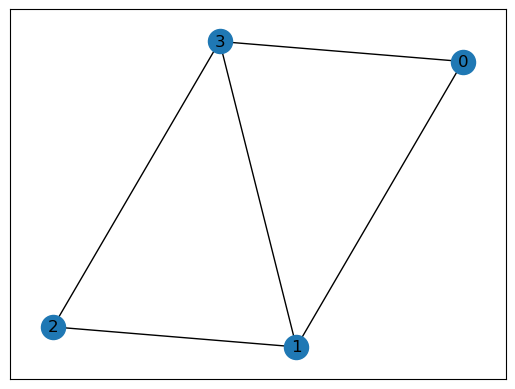

In [1]:
import networkx as nx
# Initialize an empty graph
G = nx.Graph()
# Define the nodes
qubits = [0, 1, 2, 3]
# Add the edges
G.add_edges_from([(qubits[0], qubits[1]), (qubits[1], qubits[2]), (qubits[2], qubits[3]), (qubits[3], qubits[0]), (qubits[3], qubits[1])])
# Plot the graph
nx.draw_networkx(G)

Now we shall write our QAOA program with pyQuil. We will be using the `WavefunctionSimulator` for the simulation of our quantum circuit. With the simulator, we will be able to obtain complete form of the wavefunction which includes the phases and amplitudes of each bitstring. Consequently, this allows us to conveniently see the effects of the action of the Cost and Mixer Hamiltonians as we add them to our quantum circiuts, in particular, how the phases and amplitudes changes, which we will now go through.

In [2]:
from pyquil import Program
from pyquil.api import WavefunctionSimulator
from pyquil.gates import *
from pyquil.paulis import *

wfn_sim = WavefunctionSimulator()

Let us define the Cost and Mixer terms.

In [25]:
q0, q1, q2, q3 = qubits
# Cost term
cost = 0.5*(5*ID() - sZ(q0) * sZ(q1) - sZ(q1) * sZ(q2) - sZ(q2) * sZ(q3) - sZ(q3) * sZ(q0) - sZ(q3) * sZ(q1)) 
# Mixer term
mixer = sX(q0) + sX(q1)+ sX(q2)+ sX(q3)

Then, we build the quantum circuit as explained above. We take $p=1$, which means we just have two parametric variables $\gamma, \beta$, i.e. one layer. The initial state as discussed above is the Hadamard state. 

In [4]:
# Initialize an empty program for our circuit
qaoa_prog = Program()

# Declare the parametric variables to optimize
gamma = qaoa_prog.declare('gamma', 'REAL', 1)
beta = qaoa_prog.declare('beta', 'REAL', 1)

# Create the initial state
for q in qubits:
    qaoa_prog += H(q)

Recall that the initial state is the equal superposition of all posible partitions/solutions, so all solutions are equally likely. Furthermore, their phases are also equal.

In [6]:
# Wavefunction
wfn = wfn_sim.wavefunction(qaoa_prog, memory_map={'gamma': [gamma], 'beta': [beta]})

# Phases of bitstrings from wavefunction
print("Phases")
phases_1 = []
for i in range(16):
    phases_1.append(np.angle(wfn.amplitudes[i])/np.pi)
    print(format(i, '04b'),":", phases_1[i])
    
# Amplitudes of bitstrings from wavefunction
print("Amplitudes")
amplitudes_1 = []
for i in range(16):
    amplitudes_1.append(np.abs(wfn.amplitudes[i]))
    print(format(i, '04b'),":", amplitudes_1[i])

Phases
0000 : 0.0
0001 : 0.0
0010 : 0.0
0011 : 0.0
0100 : 0.0
0101 : 0.0
0110 : 0.0
0111 : 0.0
1000 : 0.0
1001 : 0.0
1010 : 0.0
1011 : 0.0
1100 : 0.0
1101 : 0.0
1110 : 0.0
1111 : 0.0
Amplitudes
0000 : 0.24999999999999992
0001 : 0.24999999999999992
0010 : 0.24999999999999992
0011 : 0.24999999999999992
0100 : 0.24999999999999992
0101 : 0.24999999999999992
0110 : 0.24999999999999992
0111 : 0.24999999999999992
1000 : 0.24999999999999992
1001 : 0.24999999999999992
1010 : 0.24999999999999992
1011 : 0.24999999999999992
1100 : 0.24999999999999992
1101 : 0.24999999999999992
1110 : 0.24999999999999992
1111 : 0.24999999999999992


We use `exponential_map` from pyQuil to exponentiate the Cost and Mixer terms. Applying the cost hamiltonian leaves amplitudes unchanged, but changes the phases of the bitstrings. In particular, the change of phases for the two 'correct' states $\ket{0101}$ or $\ket{1010}$ are larger than the 'incorrect' ones. The mixer Hamiltonian leaves the phases unchanged, but increases the amplitudes of the 'correct' states and generally decreases amplitudes of the 'incorrect' states. The change in amplitudes is in proportion to change of phases from applying the cost Hamiltonian. Ase choose add the cost and mixer Hamiltonian, we also need to choose two initial values for the parametric variables $\gamma$ and $\beta$.

In [7]:
# Add the Cost Hamiltonian
for cost_term in cost:
    qaoa_prog += exponential_map(cost_term)(gamma)

In [9]:
# Initial parameter value
gamma= 0.1

# Wavefunction
wfn = wfn_sim.wavefunction(qaoa_prog, memory_map={'gamma': [gamma], 'beta': [beta]})

# Amplitudes of bitstrings
print("Phases")
phases_2 = []
for i in range(16):
    phases_2.append(np.angle(wfn.amplitudes[i])/np.pi)
    print(format(i, '04b'),":", phases_2[i])
    
# Amplitudes of bitstrings
print("Amplitudes")
amplitudes_2 = []
for i in range(16):
    amplitudes_2.append(np.abs(wfn.amplitudes[i]))
    print(format(i, '04b'),":", amplitudes_2[i])

Phases
0000 : -6.626155586382329e-18
0001 : -0.06366197723675815
0010 : -0.09549296585513725
0011 : -0.0954929658551372
0100 : -0.06366197723675814
0101 : -0.1273239544735163
0110 : -0.09549296585513722
0111 : -0.0954929658551372
1000 : -0.0954929658551372
1001 : -0.09549296585513722
1010 : -0.1273239544735163
1011 : -0.06366197723675814
1100 : -0.0954929658551372
1101 : -0.09549296585513725
1110 : -0.06366197723675815
1111 : -6.626155586382329e-18
Amplitudes
0000 : 0.24999999999999994
0001 : 0.24999999999999994
0010 : 0.24999999999999992
0011 : 0.24999999999999997
0100 : 0.24999999999999994
0101 : 0.24999999999999994
0110 : 0.2499999999999999
0111 : 0.24999999999999997
1000 : 0.24999999999999997
1001 : 0.2499999999999999
1010 : 0.24999999999999994
1011 : 0.24999999999999994
1100 : 0.24999999999999997
1101 : 0.24999999999999992
1110 : 0.24999999999999994
1111 : 0.24999999999999994


In [11]:
# Add the Mixer Hamiltonian
for mixer_term in mixer:
    qaoa_prog += exponential_map(mixer_term)(beta)

In [12]:
# Initial parameter value
beta= 0.1

# Wavefunction
wfn = wfn_sim.wavefunction(qaoa_prog, memory_map={'gamma': [gamma], 'beta': [beta]})

# Amplitudes of bitstrings
print("Phases")
phases_3 = []
for i in range(16):
    phases_3.append(np.angle(wfn.amplitudes[i])/np.pi)
    print(format(i, '04b'),":", phases_3[i])
    
# Amplitudes of bitstrings
print("Amplitudes")
amplitudes_3 = []
for i in range(16):
    amplitudes_3.append(np.abs(wfn.amplitudes[i]))
    print(format(i, '04b'),":", amplitudes_3[i])

Phases
0000 : -0.12971353030929936
0001 : -0.190788478427157
0010 : -0.2202141331938691
0011 : -0.22116588730804562
0100 : -0.19078847842715702
0101 : -0.24950864528337496
0110 : -0.22116588730804568
0111 : -0.22021413319386904
1000 : -0.22021413319386904
1001 : -0.22116588730804568
1010 : -0.24950864528337496
1011 : -0.19078847842715702
1100 : -0.22116588730804562
1101 : -0.2202141331938691
1110 : -0.190788478427157
1111 : -0.12971353030929936
Amplitudes
0000 : 0.22550591312562865
0001 : 0.24471327627649897
0010 : 0.25435363886757667
0011 : 0.25498636690975685
0100 : 0.24471327627649894
0101 : 0.264481126251742
0110 : 0.2549863669097568
0111 : 0.2543536388675768
1000 : 0.2543536388675768
1001 : 0.2549863669097568
1010 : 0.264481126251742
1011 : 0.24471327627649894
1100 : 0.25498636690975685
1101 : 0.25435363886757667
1110 : 0.24471327627649897
1111 : 0.22550591312562865


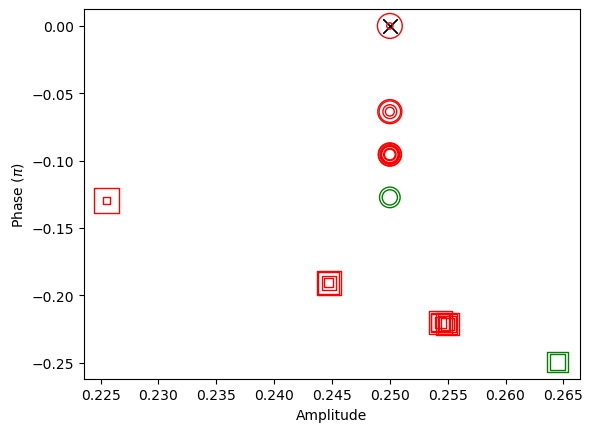

In [47]:
# Plot phases and amplitudes of bitstrings
import matplotlib.pyplot as plt

# Marker colors
colormap = ['r','r','r','r','r','g','r','r','r','r','g','r','r','r','r','r']

# Marker sizes
size = [20,40,60,80,100,120,140,160,180,200,220,240,260,280,300,320]

plt.xlabel("Amplitude")
plt.ylabel("Phase ($\pi$)")

# Phases and amplitudes after initialization denoted by 'X'
plt.scatter(amplitudes_1, phases_1,c= 'k', marker='x', s=100, linewidths=0.4)

# Phases and amplitudes after applying cost Hamiltonian denoted by 'circles'
plt.scatter(amplitudes_2, phases_2, marker='o', s=size, facecolors='none', edgecolors= colormap)
# Phases and amplitudes after applying mixer Hamiltonian denoted by 'squares'
plt.scatter(amplitudes_3, phases_3, s=size,marker='s', facecolors='none', edgecolors= colormap)
# A different marker size is taken for each bitstring, so we can see the distribution of bitstrings 
# 'Correct' bitstrings '0101' and '1010' are green, the rest are red

plt.show()

So far, the results we obtain show the idealized situation and the probability to obtain the correct solution is generally greater than the incorrect solution. Let us now carry out a quantum simulation for a number of times to see what we get.

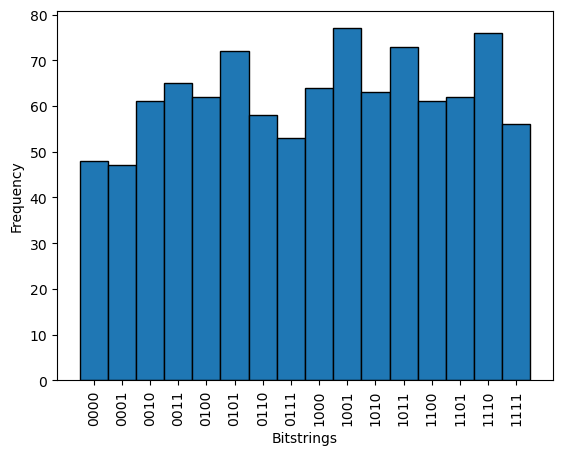

In [20]:
# Number of shots  to take
samples = wfn.sample_bitstrings(n_samples=1000)

# List shots results
sampleslist=[]
for y in range(len(samples)-1):
    sampleslist.append(''.join([str(x) for x in samples[y]]))
    
sampleslistint=[]
for z in range(len(sampleslist)-1):
    sampleslistint.append(int(sampleslist[z], base=2))

# Plot shots results
import matplotlib.pyplot as plt

xticks = range(2**len(qubits))
xtick_labels = list(map(lambda x: format(x, "04b"), xticks))
bins = np.arange(0, 2**len(qubits)+1) - 0.5

plt.xlabel("Bitstrings")
plt.ylabel("Frequency")
plt.xticks(xticks, xtick_labels, rotation="vertical")
plt.hist(sampleslistint, bins=bins, edgecolor='black')
plt.show()

How do results compare with idealized situation? Let us also compute the expectation with the current wavefunction. This is the value that we want to maximize in order to find our optimal solution.

In [29]:
expect = wfn_sim.expectation(qaoa_prog, cost, memory_map={'gamma': [gamma], 'beta': [beta]})
print(np.abs(expect))

2.5952446808151213


Since our Hamiltonian problem is still rather simple, we can compute the true maximum eigenvalue to compare with the expectation.

In [32]:
from pyquil.simulation.tools import lifted_pauli

# Obtain the matrix form of the Cost Hamiltonian
mat = lifted_pauli(cost, cost.get_qubits())

# Obtain Cost Hamiltonian eigenvalues
eigvals, eigvecs = np.linalg.eig(mat)

# Obtain the maximum eigenvalue
max_eigval = np.max(eigvals)

# Print the maximum eigenvalue, checking it is real
assert np.isclose(max_eigval.imag, 0.0)   
max_eigval = np.real(max_eigval)
print(f"Max eigenvalue: {np.abs(max_eigval)}")

Max eigenvalue: 4.0


How do the expectations compare? Now let use continue by carrying out a classical optimization. There exists many different optimization methods. Some are gradient-based, meaning one needs to provide information on the gradient to optimize, others do not. We shall use one of the latter ones called `COBYLA` from the [SciPy Optimization Library](https://docs.scipy.org/doc/scipy/reference/optimize.html).

In [33]:
from scipy.optimize import minimize

In [37]:
# Objective function for optimization
def objective(angles):
    global wfn_sim
    global qaoa_prog
    global cost
    gamma,beta = angles
    obs = -wfn_sim.expectation(qaoa_prog, cost, memory_map={'gamma': [gamma], 'beta': [beta]})
    return obs

In [45]:
initial_guess = (gamma, beta)

result = minimize(objective, initial_guess, method='COBYLA')

print(f"Success: {result.success}")
print(f"Optimal value: {np.abs(result.fun)}")
print(f"Optimal angles: {result.x}")


Success: True
Optimal value: 2.879477190466592
Optimal angles: [0.65273686 0.09525592]


How does the optimization compare before and now after running COBYLA? Let us run quantum simulations again, but now with optimized parameters.

In [46]:
gamma = result.x[0]
beta = result.x[1]

# Optimized wavefunction
wfn = wfn_sim.wavefunction(qaoa_prog, memory_map={'gamma': [gamma], 'beta': [beta]})

# Shots from optimized wavefunction
samples = wfn.sample_bitstrings(n_samples=1000)

# List shot results
sampleslist=[]
for y in range(len(samples)-1):
    sampleslist.append(''.join([str(x) for x in samples[y]]))

sampleslistint=[]
for z in range(len(sampleslist)-1):
    sampleslistint.append(int(sampleslist[z], base=2))

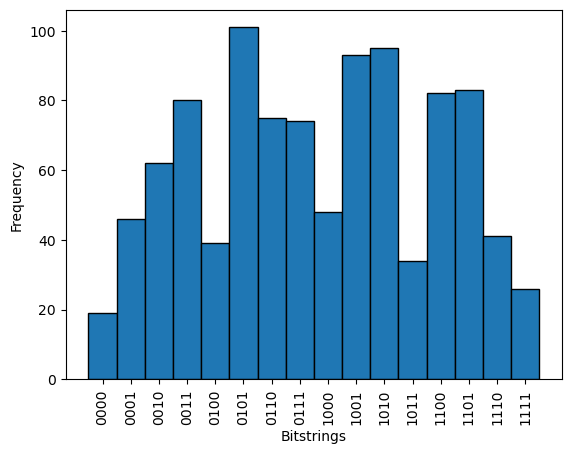

In [44]:
import matplotlib.pyplot as plt

xticks = range(2**len(qubits))
xtick_labels = list(map(lambda x: format(x, "04b"), xticks))
bins = np.arange(0, 2**len(qubits)+1) - 0.5

plt.xlabel("Bitstrings")
plt.ylabel("Frequency")
plt.xticks(xticks, xtick_labels, rotation="vertical")
plt.hist(sampleslistint, bins=bins, edgecolor='black')
plt.show()

### Task

Repeat the above example for more layers of the quantum circuit, i.e. for $p=2,3$ etc. What do you notice about the perfomance?

### References

[1] M. S. Alam, Rigetti Computing Lectures, IBA Karachi (2020).

[2] E. Farhi, J. Goldstone, and S. Gutmann, A Quantum Approximate Optimization Algorithm, arXiv.1411.4028 (2014).